<h1 style="font-family:Papyrus; font-size:3em" align="center"> <img src="data/rar.png"  height="45" width="45" > <b>Project №3 'EDA'</b> <img src="data/rar.png"  height="45" width="45" >
</h1>


## Import libs and define constants

In [774]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# функция для скорректированного iqr
# from statsmodels.stats.stattools import medcouple

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn.metrics import matthews_corrcoef
# Загружаем специальный удобный инструмент для разделения датасета:
\
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [775]:
RANDOM_SEED = 42

In [776]:
!pip freeze > requirements.txt

In [777]:
# Подгрузим наши данные из соревнования
# DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = './data/' # home dir
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

### Взглянем на начальные данные


In [778]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [779]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [780]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Соединим train и test выборки для совместных преобразований

In [781]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\mblyz\AppData\Local\Temp\ipykernel_8076\1295228875.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [782]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Проведем небольшой разведывательный анализ, создадим новые признаки


In [783]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

In [784]:
# булевы маски для удобного доступа к train и test данным
train_mask = data['sample'] == 1 
test_mask = data['sample'] == 0

In [785]:
data.drop('hotel_name', axis=1, inplace=True) # не нашел ничего полезного в названии отеля

Выделим страну из адреса, предварительно посмотрев что имеется 6 уникальных стран, сразу же закодируем в числовой признак и откинем признак адреса

In [786]:
data['country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data = pd.get_dummies(data, columns=['country'])
data.drop(['hotel_address', 'reviewer_nationality'], axis=1, inplace=True)

Поработаем с датой обзора, добавим признак времени года в числовом виде и сразу же закодируем его one_hot методом

In [787]:
data['review_date'] = pd.to_datetime(data['review_date'])    
data['season'] = data['review_date'].apply(lambda date: date.month%12 //3 + 1)
data = pd.get_dummies(data=data, columns=['season'])

In [788]:
data.drop('review_date', inplace=True, axis=1) # удалим дату, так как для обучения модели она непригодна

In [789]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0])) # Выделим количество дней

Посмотрим на основные ключевые слова в хороших отзывах

In [790]:
data['positive_review'].value_counts().nlargest(12)

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
 Breakfast           608
 Friendly staff      515
Name: positive_review, dtype: int64

Создадим бинарные признак в зависимости от основных ключевых слов в положительном отзыве

In [791]:

def pos_is_location(review):
    review = review.lower()
    if 'location' in review or 'position' in review or 'view' in review:
        return 1
    else:
        return 0


def pos_is_nothing(review):
    review = review.lower()
    if 'nothing' in review:
        return 1
    else:
        return 0


def pos_is_everything(review):
    review = review.lower()
    if 'every' in review or 'all' in review:
        return 1
    else:
        return 0


def pos_is_staff(review):
    review = review.lower()
    if 'staff' in review or 'serv' in review:
        return 1
    else:
        return 0


def pos_is_breakfast(review):
    review = review.lower()
    if 'breakfast' in review:
        return 1
    else:
        return 0


def pos_is_room(review):
    if 'room' in review or 'view ' in review or 'spa' in review or 'clean' in review:
        return 1
    else:
        return 0
    

data['pos_is_location'] = data['positive_review'].apply(pos_is_location)
data['pos_is_nothing'] = data['positive_review'].apply(pos_is_nothing)
data['pos_is_everything'] = data['positive_review'].apply(pos_is_everything)
data['pos_is_staff'] = data['positive_review'].apply(pos_is_staff)
data['pos_is_breakfast'] = data['positive_review'].apply(pos_is_breakfast)
data['pos_is_room'] = data['positive_review'].apply(pos_is_room)
data.drop('positive_review', axis=1, inplace=True)

Сделаем то же самое для признака негативных отзывов

In [792]:
data['negative_review'].value_counts(True).nlargest(15)*100


No Negative        24.797475
 Nothing            2.771756
 Nothing            0.821347
 nothing            0.431421
 N A                0.201071
 None               0.190795
                    0.164618
 N a                0.098694
 Breakfast          0.078916
 Small room         0.072324
 Location           0.071354
 Everything         0.063210
 All good           0.061659
 Nothing really     0.061271
 none               0.058557
Name: negative_review, dtype: float64

Посмотрим что представляют из себя пробелы в плохом отзыве

In [793]:
data[(data['negative_review']==' N A') & (data['sample']==1)]['reviewer_score'].value_counts()

10.0    470
9.6     139
9.2      78
8.8      35
8.3      31
7.9      25
7.5      18
9.0       1
8.0       1
2.5       1
6.3       1
6.7       1
9.5       1
Name: reviewer_score, dtype: int64

In [794]:
data['negative_review'].value_counts().nlargest(15)

No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: negative_review, dtype: int64

In [795]:
# data[data['negative_review'].str.find('All') != -1]['negative_review'].to_csv('temp.csv')
# это нужно было для ручного отбора ключевых слов в негативных отзывах

In [796]:
def neg_everything_ok(row):
    row = row.lower()
    if 'no negative' in row or 'nothing' in row or 'n a' in row or 'none' in row or row ==' ' or \
    'all good' in row:
        return 1
    else:
        return 0

def neg_location(row):
    row = row.lower()
    if 'location' in row or 'position' in row or 'view' in row:
        return 1
    else:
        return 0


def neg_everything_bad(row):
    row = row.lower()
    if 'everything' in row or row == ' all' :
        return 1
    else:
        return 0

def neg_staff(row):
    row = row.lower()
    if 'staff' in row or 'serv' in row:
        return 1
    else:
        return 0


def neg_breakfast(row):
    row = row.lower()
    if 'breakfast' in row:
        return 1
    else:
        return 0


def neg_room(row):
    if 'room' in row or 'spa' in row or 'clean' in row:
        return 1
    else:
        return 0
data['neg_location'] = data['negative_review'].apply(neg_location)
data['neg_everything_ok'] = data['negative_review'].apply(neg_everything_ok)
data['neg_everything_bad'] = data['negative_review'].apply(pos_is_everything)
data['neg_staff'] = data['negative_review'].apply(neg_staff)
data['neg_breakfast'] = data['negative_review'].apply(neg_breakfast)
data['neg_room'] = data['negative_review'].apply(neg_room)
data.drop('negative_review', axis=1, inplace=True)

Также создадим признак отношения числа "пустых отзывов" к общему числу отзывов

In [797]:
data['part_of_additional_reviews'] = data['additional_number_of_scoring'] / data['total_number_of_reviews'] * 100
data.drop('additional_number_of_scoring', axis=1, inplace=True)

## Работаем с тегами:


Создадим признак количества тегов и признак количества ночей проживания клиента

In [798]:
def get_nights(tags):
    """ На сколько ночей был снят номер

    Args:
        tags (str): Список в виде строки с тегами,
        откуда можно изъять тег кол-ва ночей

    Returns:
        int: кол-во ночей
    """
    tags = list(tags[1:-1].replace('\'', '').split(', '))
    flag = False
    for i in range(len(tags)):
        if 'night' in tags[i] and (tags[i].split()[-2]).isdigit():
            flag = True
            break
    if flag:
        return int(tags[i].split()[-2])
    else:
        return -1
data['tags_count'] = data['tags'].apply(lambda x: len(list(x[1:-1].replace('\'', '').split(', '))))
data['nights_count'] = data['tags'].apply(get_nights)

Также создадим бинарный признак подтверждения с мобильного телефона и признак типа поездки (командировка или отдых или неизвестный тип)

In [799]:
data['type_of_trip'] = data['tags'].apply(lambda x: 'b' if 'business' in x.lower() else 'l' if 'leisure' in x.lower() else 'u')
data = pd.get_dummies(data, columns=['type_of_trip']) # сразу же закодируем этот признак
data['mobile_submit'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)



In [800]:
data.drop('tags', axis=1, inplace=True)

Удалим дубликаты из train выборки

In [801]:

dupl_mask = (data.duplicated()) & (data['sample'] == 1)
print(dupl_mask.value_counts())
data.drop((dupl_mask[dupl_mask==True].index), inplace=True)

False    515418
True        320
dtype: int64


## Посмотрим на корреляцию и удалим сильно связанные признаки

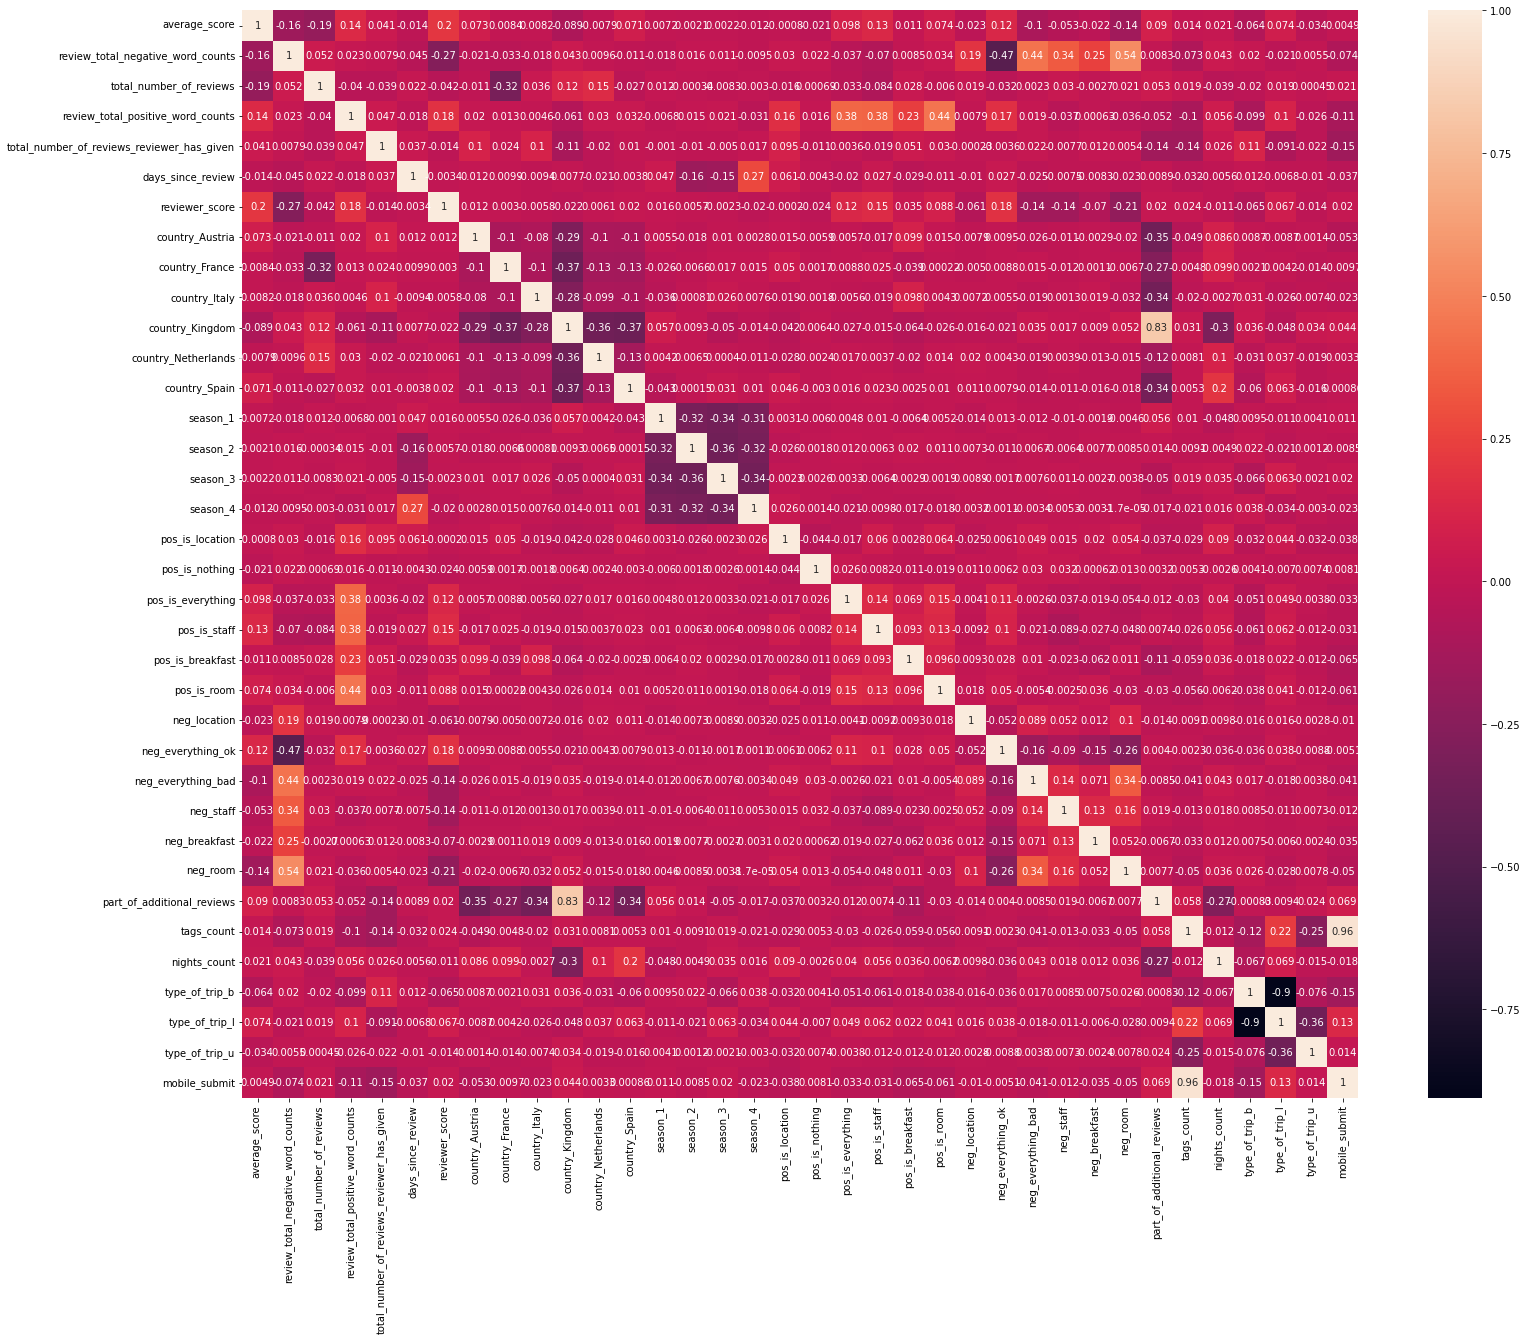

In [802]:
plt.figure(figsize=(25,20))
sns.heatmap(data.drop('sample', axis=1).corr('spearman'), annot=True);

Дополнительно посмотрим на корреляцию по мэтьюсу для бинарных признаков, так как по Пирсону сравнивать их некорректно

In [803]:
matthews_corrcoef(data['type_of_trip_b'], data['type_of_trip_l'])

-0.9049308375283831

Также с помощью соответствубщего теста посмотрим на связь между бинарным и числовым признаком

In [804]:
from scipy.stats import pointbiserialr
pointbiserialr(data['mobile_submit'], data['tags_count'])

PointbiserialrResult(correlation=0.9385158761233228, pvalue=0.0)

In [805]:
pointbiserialr(data['country_Kingdom'], data['part_of_additional_reviews'])

PointbiserialrResult(correlation=0.8269930204031248, pvalue=0.0)

Исходя из результатов выше удалим скоррелированные признаки

In [806]:
data.drop(columns=['tags_count', 'type_of_trip_l', 'country_Kingdom'], inplace=True, axis=0)

In [807]:
train_data = data.query('sample == 1')  # разделим train и test, чтобы посмотреть распределения в train выборке
test_data = data.query('sample == 0')

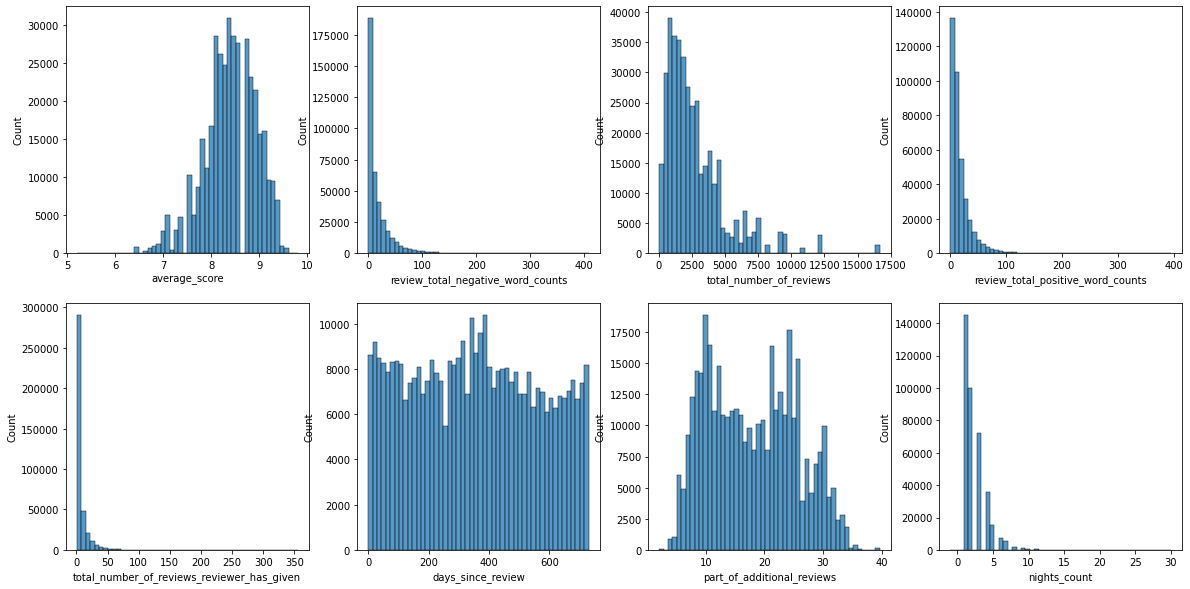

In [808]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
j=0
i=0
num_cols = [col for col in train_data.columns if (data[col].dtypes == 'float64' or data[col].dtypes == 'int64') and data[col].max() >3]
num_cols.remove('reviewer_score')
for col in list(num_cols):
    sns.histplot(train_data[col], ax=ax[i][j], bins=50)
    j+=1
    if j % 4 == 0:
        j=0
        i+=1


### Нормализуем признаки, используя MinMax Scaler

In [809]:
std_cols = list(data.columns)
std_cols.remove('reviewer_score')
std_cols.remove('sample')
data[std_cols] = MinMaxScaler().fit_transform(data[std_cols])



## Теперь разделим train и test выборки для обучения модели

In [810]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [811]:
# Откажемся от holdout выборки и отдадим под обучение весь train датасет

In [812]:
X.shape, y.shape 

((386483, 32), (386483,))

In [813]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386483 entries, 128935 to 515737
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386483 non-null  float64
 1   review_total_negative_word_counts           386483 non-null  float64
 2   total_number_of_reviews                     386483 non-null  float64
 3   review_total_positive_word_counts           386483 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  386483 non-null  float64
 5   days_since_review                           386483 non-null  float64
 6   country_Austria                             386483 non-null  float64
 7   country_France                              386483 non-null  float64
 8   country_Italy                               386483 non-null  float64
 9   country_Netherlands                         386483 non-null  floa

In [814]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [815]:
# Обучаем модель на тестовом наборе данных
model.fit(X, y)
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.2s finished


In [816]:
# print('MAPE:', metrics.mean_absolute_percentage_error(y_pred, y))

<AxesSubplot:>

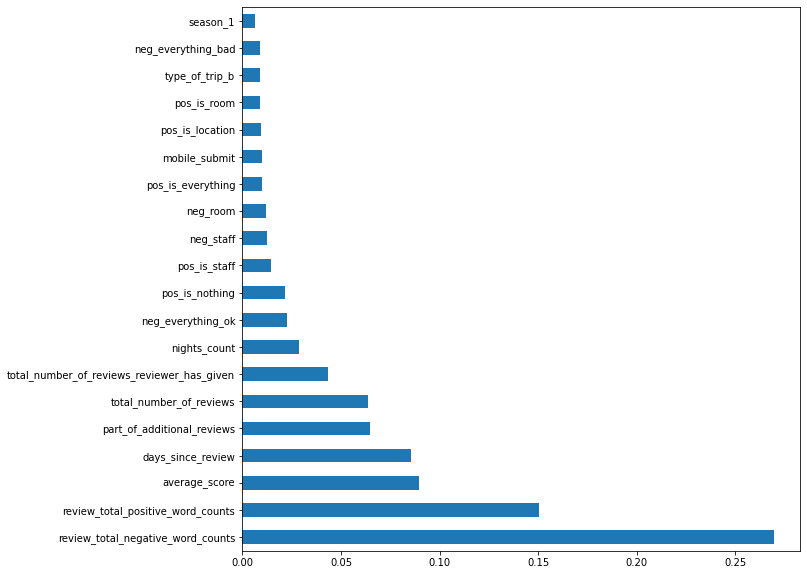

In [817]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [818]:
X.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,country_Austria,country_France,country_Italy,country_Netherlands,...,neg_everything_ok,neg_everything_bad,neg_staff,neg_breakfast,neg_room,part_of_additional_reviews,nights_count,type_of_trip_b,type_of_trip_u,mobile_submit
448379,0.543478,0.036765,0.086726,0.000000,0.025424,0.113699,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.296238,0.06250,1.0,0.0,1.0
150199,0.782609,0.000000,0.061827,0.149367,0.002825,0.352055,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.691988,0.09375,0.0,0.0,1.0
486114,0.652174,0.068627,0.093222,0.025316,0.002825,0.961644,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.229148,0.06250,0.0,0.0,0.0
330001,0.565217,0.017157,0.132796,0.000000,0.025424,0.186301,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.222991,0.12500,0.0,0.0,1.0
363070,0.630435,0.017157,0.252902,0.022785,0.008475,0.693151,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166440,0.12500,0.0,0.0,1.0
168368,0.543478,0.000000,0.011006,0.020253,0.000000,0.893151,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.568445,0.06250,0.0,0.0,0.0
146714,0.717391,0.134804,0.394118,0.032911,0.000000,0.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.428028,0.06250,1.0,0.0,1.0
442156,0.695652,0.169118,0.142058,0.012658,0.002825,0.213699,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.452526,0.12500,0.0,0.0,1.0
446934,0.739130,0.014706,0.032718,0.007595,0.008475,0.208219,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.873024,0.12500,0.0,0.0,0.0
501402,0.891304,0.164216,0.007879,0.096203,0.005650,0.961644,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.525640,0.12500,0.0,0.0,0.0


In [819]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [820]:
predict_submission = model.predict(test_data)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.5s finished


array([9.032, 7.108, 7.726, ..., 8.163, 9.557, 7.749])

In [821]:
sample_submission['reviewer_score'] = predict_submission.round(3)
sample_submission.head(10)
sample_submission.to_csv('submission.csv', index=False)
    

In [822]:
sample_submission

,reviewer_score,id
0,9.032,488440
1,7.108,274649
2,7.726,374688
3,9.608,404352
4,9.548,451596
...,...,...
128930,8.688,495812
128931,8.446,315577
128932,8.163,511968
128933,9.557,303386
